<a href="https://colab.research.google.com/github/AjibolaPy/AjibolaPy/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import time
from keras.models import Model, Sequential
import PIL
import scipy
from keras.layers import Conv2DTranspose, Concatenate, Conv2D, Input
import numpy as np
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
!unzip '/content/Semantic segmentation dataset.zip'

In [ ]:
images=[]
for path, folder, file in os.walk('/content/Semantic segmentation dataset'):
    x=0
    if path.endswith('images'):
        for i in file:
            if i.endswith('.jpg'):
                images.append(plt.imread(os.path.join(path, i)))
                
    


In [ ]:
masks=[]
for path, folder, files in os.walk('/content/Semantic segmentation dataset'):
    if path.split('/')[-1]=='masks':
      for i in files:
        masks.append(plt.imread(os.path.join(path, i)))
        

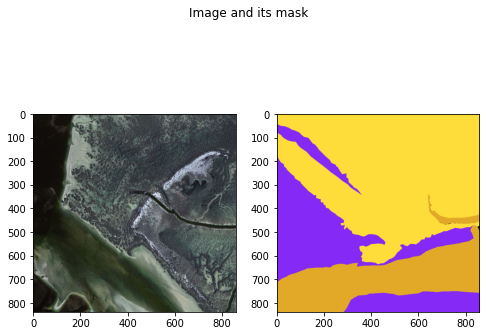

In [ ]:
plt.figure(figsize=(8,6))

plt.subplot(121)
plt.suptitle('Image and its mask')
plt.imshow(images[3])
plt.subplot(122)
plt.imshow(masks[3])

In [ ]:
def upsample(conn, step, filters):
    upsample=Conv2DTranspose(filters,(3,3),activation='relu', padding='same', strides=2)(conn)
    concat=Concatenate()([upsample,step])
    out1=Conv2D(filters,(3,3) ,padding='same')(concat)
    output=Conv2D(filters,(3,3) ,padding='same')(out1)
    return output

In [ ]:
convnet=ResNet101V2(weights='imagenet',input_shape=(1024, 1024, 3), include_top=False)
#convnet.input_shape=(200, 200, 3)
convnet.summary()

171327488/171317808 [==============================] - 1s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1030, 1030,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 512, 512, 64  9472        ['conv1_pad[0][0]']              
                     

In [ ]:
def RES_UNET(num_classes, activation_head):
    """COMBINED POWER OF RESNET101V2 AND UNET"""
    cc=convnet.input
    step1=convnet.get_layer('input_1').output #1024
    step2=convnet.get_layer('conv1_conv').output #512
    step3=convnet.get_layer('conv2_block1_1_conv').output #256
    step4=convnet.get_layer('conv2_block3_2_conv').output #128
    step5=convnet.get_layer('conv3_block4_2_conv').output #64
    
    """ BRIDGE"""
    bridge=convnet.get_layer('conv4_block23_2_conv').output #32
    
    """DECODER PART"""
    
    up1=upsample(conn=bridge, filters=64, step=step5)
    up2=upsample(conn=up1, filters=128, step=step4)
    up3=upsample(conn=up2, filters=256, step=step3)
    up4=upsample(conn=up3, filters=512, step=step2)
    up5=upsample(conn=up4, filters=1024, step=step1)
    out=Conv2D(num_classes, 1, activation=activation_head)(up5)
    return Model(convnet.input, out)

    
RES_UNET(8, 'softmax').summary()

In [ ]:
img=np.array([cv2.resize(i, (1024, 1024))/255 for i in images])
mask=np.array([cv2.resize(i, (1024, 1024))/255 for i in masks])
img
#pr=preprocess_input(mask)

In [ ]:
calls=[EarlyStopping(monitor='training_loss', patience=5,mode='min', restore_best_weights=True), ModelCheckpoint(monitor='training_loss', 
                                                                                                                 verbose=1,
                                                                                                                 save_best_only=True, 
                                                                                                                 mode='min', filepath='/content/semantic weight')]

In [ ]:
from gc import callbacks
model=RES_UNET(8, 'softmax')
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-3))
model.fit(x=img, y=pr, epochs=20, callbacks=calls, batch_size=30)